embed dim 4096
interaction_indexes [9, 19, 29, 39]
patch_size 16


(-0.5, 383.5, 383.5, -0.5)

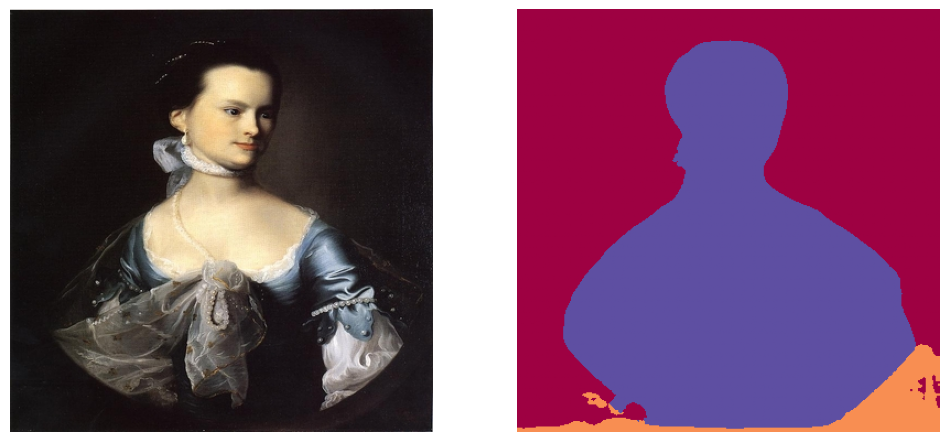

In [2]:
import sys
REPO_DIR = "/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/ImageCounterfactualExplanations/ParallelDivision/ObjectDetectionResults/dinov3"
sys.path.append(REPO_DIR)
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import colormaps
from functools import partial
from dinov3.eval.segmentation.inference import make_inference

def get_img():
    import requests
    url = "/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/ImageCounterfactualExplanations/ParallelDivision/Artstyle/correct_classification_exp&newimg/neoclassicism/Input_portrait_of_elizabeth_deering_wentworth_gould_rogers_also_known_as_mr._nathaniel_rogers.jpg.png"
    image = Image.open(url).convert("RGB")
    return image
def make_transform(resize_size: int | list[int] = 768):
    to_tensor = transforms.ToTensor()
    resize = transforms.Resize((resize_size, resize_size), antialias=True)
    normalize = transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    return transforms.Compose([to_tensor, resize, normalize])
segmentor = torch.hub.load(REPO_DIR,model='dinov3_vit7b16_ms', source="local", segmentor_weights="/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/ImageCounterfactualExplanations/ParallelDivision/ObjectDetectionResults/dinov3_vit7b16_ade20k_m2f_head-bf307cb1.pth", backbone_weights="/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/ImageCounterfactualExplanations/ParallelDivision/ObjectDetectionResults/dinov3_vit7b16_pretrain_lvd1689m-a955f4ea.pth")

img_size = 384
img  = get_img()
transform = make_transform(img_size)
with torch.inference_mode():
    with torch.autocast('cuda', dtype=torch.bfloat16):
        batch_img = transform(img)[None]
        pred_vit7b = segmentor(batch_img)  # raw predictions  
        # actual segmentation map
        segmentation_map_vit7b = make_inference(
            batch_img,
            segmentor,
            inference_mode="slide",
            decoder_head_type="m2f",
            rescale_to=(img.size[-1], img.size[-2]),
            n_output_channels=150,
            crop_size=(img_size, img_size),
            stride=(img_size, img_size),
            output_activation=partial(torch.nn.functional.softmax, dim=1),
        ).argmax(dim=1, keepdim=True)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(img)
plt.axis("off")
plt.subplot(122)
plt.imshow(segmentation_map_vit7b[0,0].cpu(), cmap=colormaps["Spectral"])
plt.axis("off")


embed dim 4096
interaction_indexes [9, 19, 29, 39]
patch_size 16
Segmentation Results:
--------------------------------------------------
Class ID   0: wall                 | Coverage:  51.49% | Pixels:    75925
Class ID  12: person               | Coverage:  44.23% | Pixels:    65223
Class ID   3: floor                | Coverage:   4.28% | Pixels:     6308


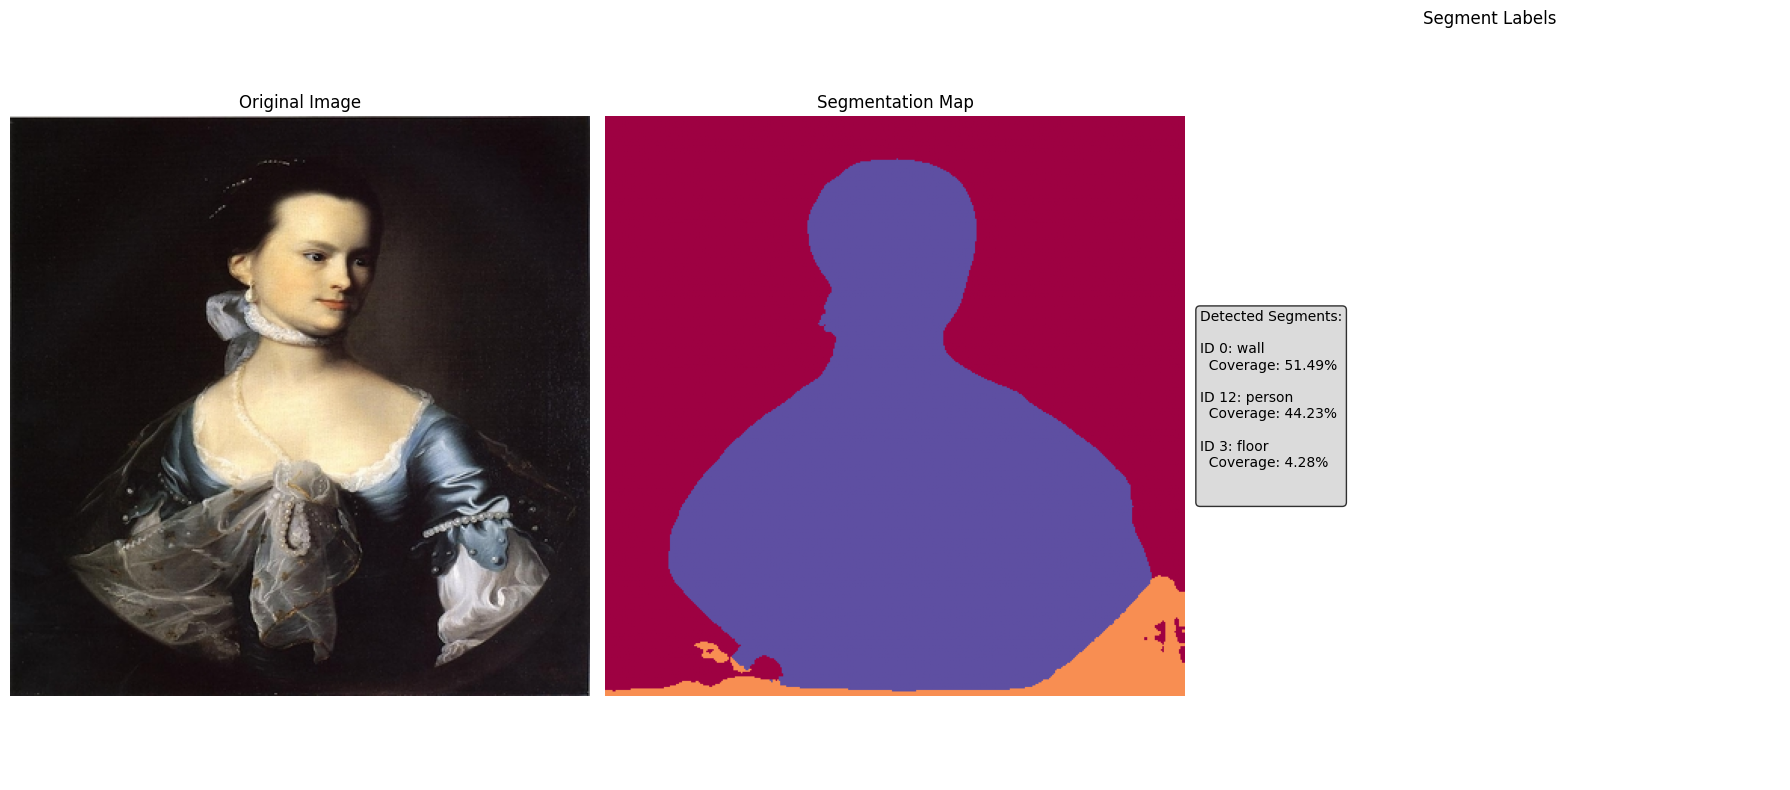


Class ID 12 is: person

Person-related segments found:
  ID 12: person (44.23%)

Wall-related segments found:
  ID 0: wall (51.49%)


In [3]:
import sys
import numpy as np
REPO_DIR = "/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/ImageCounterfactualExplanations/ParallelDivision/ObjectDetectionResults/dinov3"
sys.path.append(REPO_DIR)
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import colormaps
from functools import partial
from dinov3.eval.segmentation.inference import make_inference

# ADE20K class names (150 classes)
ADE20K_CLASSES = [
    'wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road', 'bed', 'windowpane', 'grass',
    'cabinet', 'sidewalk', 'person', 'earth', 'door', 'table', 'mountain', 'plant', 'curtain', 'chair',
    'car', 'water', 'painting', 'sofa', 'shelf', 'house', 'sea', 'mirror', 'rug', 'field',
    'armchair', 'seat', 'fence', 'desk', 'rock', 'wardrobe', 'lamp', 'bathtub', 'railing', 'cushion',
    'base', 'box', 'column', 'signboard', 'chest of drawers', 'counter', 'sand', 'sink', 'skyscraper', 'fireplace',
    'refrigerator', 'grandstand', 'path', 'stairs', 'runway', 'case', 'pool table', 'pillow', 'screen door', 'stairway',
    'river', 'bridge', 'bookcase', 'blind', 'coffee table', 'toilet', 'flower', 'book', 'hill', 'bench',
    'countertop', 'stove', 'palm', 'kitchen island', 'computer', 'swivel chair', 'boat', 'bar', 'arcade machine', 'hovel',
    'bus', 'towel', 'light', 'truck', 'tower', 'chandelier', 'awning', 'streetlight', 'booth', 'television receiver',
    'airplane', 'dirt track', 'apparel', 'pole', 'land', 'bannister', 'escalator', 'ottoman', 'bottle', 'buffet',
    'poster', 'stage', 'van', 'ship', 'fountain', 'conveyer belt', 'canopy', 'washer', 'plaything', 'swimming pool',
    'stool', 'barrel', 'basket', 'waterfall', 'tent', 'bag', 'minibike', 'cradle', 'oven', 'ball',
    'food', 'step', 'tank', 'trade name', 'microwave', 'pot', 'animal', 'bicycle', 'lake', 'dishwasher',
    'screen', 'blanket', 'sculpture', 'hood', 'sconce', 'vase', 'traffic light', 'tray', 'ashcan', 'fan',
    'pier', 'crt screen', 'plate', 'monitor', 'bulletin board', 'shower', 'radiator', 'glass', 'clock', 'flag'
]

def get_img():
    url = "/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/ImageCounterfactualExplanations/ParallelDivision/Artstyle/correct_classification_exp&newimg/neoclassicism/Input_portrait_of_elizabeth_deering_wentworth_gould_rogers_also_known_as_mr._nathaniel_rogers.jpg.png"
    image = Image.open(url).convert("RGB")
    return image

def make_transform(resize_size: int | list[int] = 768):
    to_tensor = transforms.ToTensor()
    resize = transforms.Resize((resize_size, resize_size), antialias=True)
    normalize = transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    return transforms.Compose([to_tensor, resize, normalize])

def get_segment_labels(segmentation_map, class_names=ADE20K_CLASSES):
    """
    Get labels for each segment in the segmentation map
    
    Args:
        segmentation_map: torch.Tensor of shape (H, W) with class indices
        class_names: list of class names corresponding to indices
    
    Returns:
        dict: mapping of class_id -> (class_name, pixel_count, percentage)
    """
    # Convert to numpy if it's a tensor
    if isinstance(segmentation_map, torch.Tensor):
        seg_array = segmentation_map.cpu().numpy()
    else:
        seg_array = segmentation_map
    
    # Get unique class indices and their counts
    unique_classes, counts = np.unique(seg_array, return_counts=True)
    
    total_pixels = seg_array.size
    segment_info = {}
    
    for class_id, count in zip(unique_classes, counts):
        if class_id < len(class_names):
            class_name = class_names[class_id]
        else:
            class_name = f"unknown_class_{class_id}"
        
        percentage = (count / total_pixels) * 100
        segment_info[int(class_id)] = {
            'name': class_name,
            'pixel_count': int(count),
            'percentage': round(percentage, 2)
        }
    
    return segment_info

def visualize_segments_with_labels(img, segmentation_map, segment_info):
    """
    Visualize the original image and segmentation with labels
    """
    plt.figure(figsize=(18, 8))
    
    # Original image
    plt.subplot(131)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")
    
    # Segmentation map
    plt.subplot(132)
    plt.imshow(segmentation_map, cmap=colormaps["Spectral"])
    plt.title("Segmentation Map")
    plt.axis("off")
    
    # Legend with class names
    plt.subplot(133)
    plt.axis('off')
    
    # Sort by percentage for better readability
    sorted_segments = sorted(segment_info.items(), 
                           key=lambda x: x[1]['percentage'], 
                           reverse=True)
    
    legend_text = "Detected Segments:\n\n"
    for class_id, info in sorted_segments:
        if info['percentage'] > 0.1:  # Only show segments with >0.1% coverage
            legend_text += f"ID {class_id}: {info['name']}\n"
            legend_text += f"  Coverage: {info['percentage']}%\n\n"
    
    plt.text(0, 0.5, legend_text, fontsize=10, verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    plt.title("Segment Labels")
    
    plt.tight_layout()
    plt.show()

# Load model and run inference
segmentor = torch.hub.load(REPO_DIR, model='dinov3_vit7b16_ms', source="local", 
                          segmentor_weights="/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/ImageCounterfactualExplanations/ParallelDivision/ObjectDetectionResults/dinov3_vit7b16_ade20k_m2f_head-bf307cb1.pth", 
                          backbone_weights="/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/ImageCounterfactualExplanations/ParallelDivision/ObjectDetectionResults/dinov3_vit7b16_pretrain_lvd1689m-a955f4ea.pth")

img_size = 384
img = get_img()
transform = make_transform(img_size)

with torch.inference_mode():
    with torch.autocast('cuda', dtype=torch.bfloat16):
        batch_img = transform(img)[None]
        pred_vit7b = segmentor(batch_img)
        
        segmentation_map_vit7b = make_inference(
            batch_img,
            segmentor,
            inference_mode="slide",
            decoder_head_type="m2f",
            rescale_to=(img.size[-1], img.size[-2]),
            n_output_channels=150,
            crop_size=(img_size, img_size),
            stride=(img_size, img_size),
            output_activation=partial(torch.nn.functional.softmax, dim=1),
        ).argmax(dim=1, keepdim=True)

# Get segment labels
segment_info = get_segment_labels(segmentation_map_vit7b[0, 0])

# Print detailed segment information
print("Segmentation Results:")
print("-" * 50)
for class_id, info in sorted(segment_info.items(), key=lambda x: x[1]['percentage'], reverse=True):
    if info['percentage'] > 0.1:  # Only show significant segments
        print(f"Class ID {class_id:3d}: {info['name']:20s} | "
              f"Coverage: {info['percentage']:6.2f}% | "
              f"Pixels: {info['pixel_count']:8d}")

# Visualize with labels
visualize_segments_with_labels(img, segmentation_map_vit7b[0, 0].cpu(), segment_info)

# Additional utility functions
def get_class_name_by_id(class_id, class_names=ADE20K_CLASSES):
    """Get class name for a specific class ID"""
    if class_id < len(class_names):
        return class_names[class_id]
    return f"unknown_class_{class_id}"

def find_segments_by_name(segment_info, search_name):
    """Find all segments containing a specific name"""
    matching_segments = {}
    search_name_lower = search_name.lower()
    
    for class_id, info in segment_info.items():
        if search_name_lower in info['name'].lower():
            matching_segments[class_id] = info
    
    return matching_segments

# Example usage of utility functions
print(f"\nClass ID 12 is: {get_class_name_by_id(12)}")

# Find all segments related to "person" or "wall"
person_segments = find_segments_by_name(segment_info, "person")
wall_segments = find_segments_by_name(segment_info, "wall")

if person_segments:
    print(f"\nPerson-related segments found:")
    for class_id, info in person_segments.items():
        print(f"  ID {class_id}: {info['name']} ({info['percentage']}%)")

if wall_segments:
    print(f"\nWall-related segments found:")
    for class_id, info in wall_segments.items():
        print(f"  ID {class_id}: {info['name']} ({info['percentage']}%)")

embed dim 4096
interaction_indexes [9, 19, 29, 39]
patch_size 16
Segmentation Results:
--------------------------------------------------
Class ID   2: sky                  | Coverage:  68.32% | Pixels:   100743
Class ID  12: person               | Coverage:  31.63% | Pixels:    46640


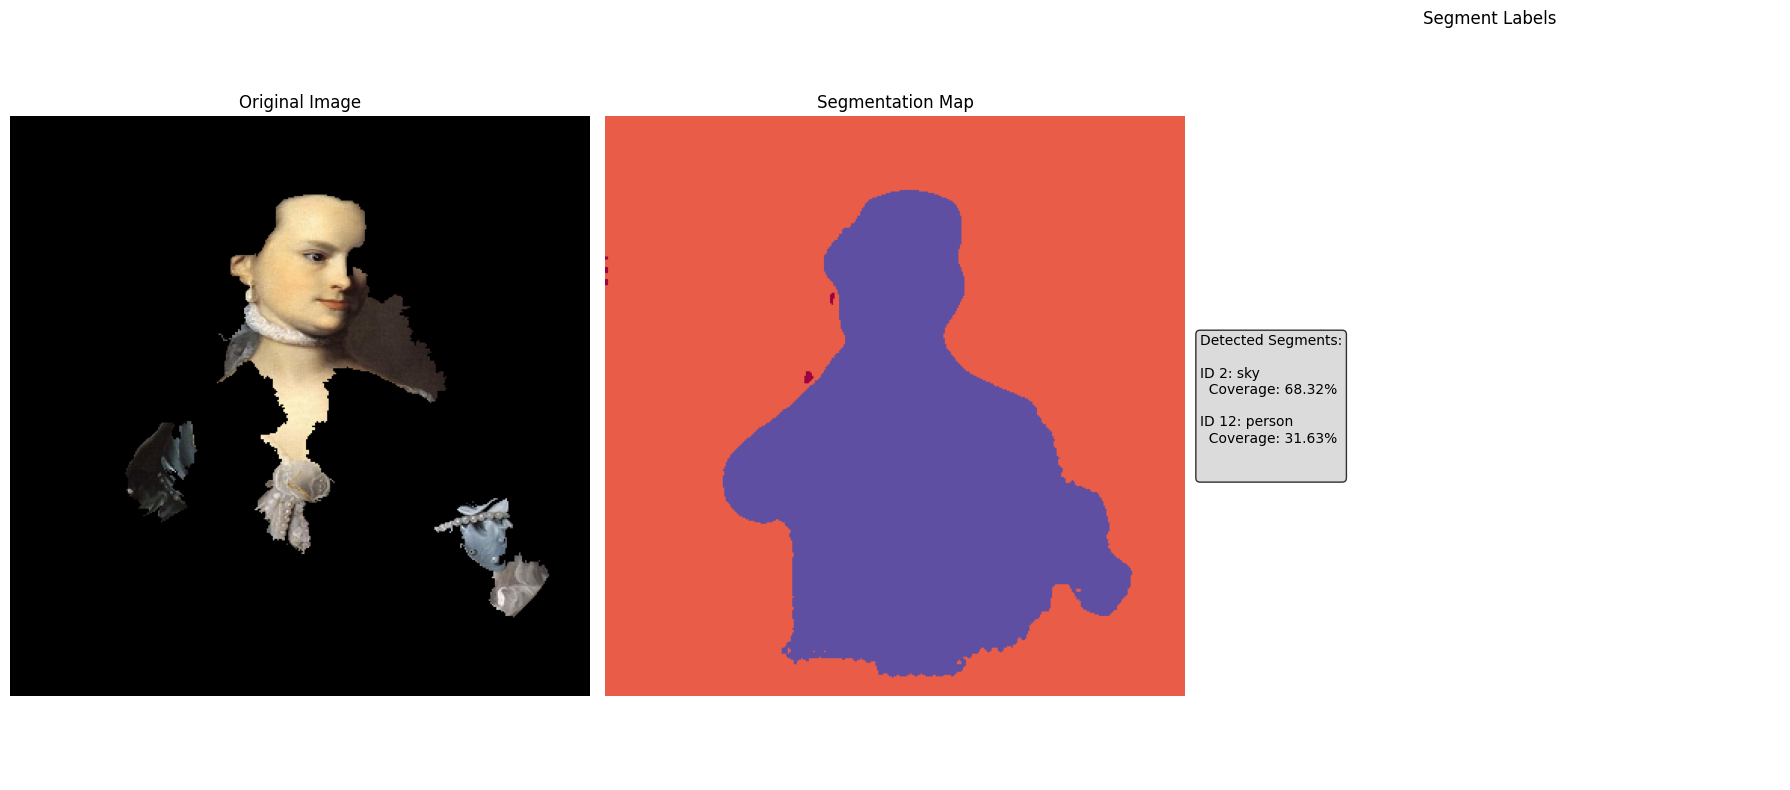


Class ID 12 is: person

Person-related segments found:
  ID 12: person (31.63%)

Wall-related segments found:
  ID 0: wall (0.05%)


In [4]:
import sys
import numpy as np
REPO_DIR = "/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/ImageCounterfactualExplanations/ParallelDivision/ObjectDetectionResults/dinov3"
sys.path.append(REPO_DIR)
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import colormaps
from functools import partial
from dinov3.eval.segmentation.inference import make_inference

# ADE20K class names (150 classes)
ADE20K_CLASSES = [
    'wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road', 'bed', 'windowpane', 'grass',
    'cabinet', 'sidewalk', 'person', 'earth', 'door', 'table', 'mountain', 'plant', 'curtain', 'chair',
    'car', 'water', 'painting', 'sofa', 'shelf', 'house', 'sea', 'mirror', 'rug', 'field',
    'armchair', 'seat', 'fence', 'desk', 'rock', 'wardrobe', 'lamp', 'bathtub', 'railing', 'cushion',
    'base', 'box', 'column', 'signboard', 'chest of drawers', 'counter', 'sand', 'sink', 'skyscraper', 'fireplace',
    'refrigerator', 'grandstand', 'path', 'stairs', 'runway', 'case', 'pool table', 'pillow', 'screen door', 'stairway',
    'river', 'bridge', 'bookcase', 'blind', 'coffee table', 'toilet', 'flower', 'book', 'hill', 'bench',
    'countertop', 'stove', 'palm', 'kitchen island', 'computer', 'swivel chair', 'boat', 'bar', 'arcade machine', 'hovel',
    'bus', 'towel', 'light', 'truck', 'tower', 'chandelier', 'awning', 'streetlight', 'booth', 'television receiver',
    'airplane', 'dirt track', 'apparel', 'pole', 'land', 'bannister', 'escalator', 'ottoman', 'bottle', 'buffet',
    'poster', 'stage', 'van', 'ship', 'fountain', 'conveyer belt', 'canopy', 'washer', 'plaything', 'swimming pool',
    'stool', 'barrel', 'basket', 'waterfall', 'tent', 'bag', 'minibike', 'cradle', 'oven', 'ball',
    'food', 'step', 'tank', 'trade name', 'microwave', 'pot', 'animal', 'bicycle', 'lake', 'dishwasher',
    'screen', 'blanket', 'sculpture', 'hood', 'sconce', 'vase', 'traffic light', 'tray', 'ashcan', 'fan',
    'pier', 'crt screen', 'plate', 'monitor', 'bulletin board', 'shower', 'radiator', 'glass', 'clock', 'flag'
]

def get_img():
    url = "/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/ImageCounterfactualExplanations/ParallelDivision/Artstyle/correct_classification_exp&newimg/neoclassicism/ReasonForOriginalClassification_portrait_of_elizabeth_deering_wentworth_gould_rogers_also_known_as_mr._nathaniel_rogers.jpg.png"
    image = Image.open(url).convert("RGB")
    return image

def make_transform(resize_size: int | list[int] = 768):
    to_tensor = transforms.ToTensor()
    resize = transforms.Resize((resize_size, resize_size), antialias=True)
    normalize = transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    return transforms.Compose([to_tensor, resize, normalize])

def get_segment_labels(segmentation_map, class_names=ADE20K_CLASSES):
    """
    Get labels for each segment in the segmentation map
    
    Args:
        segmentation_map: torch.Tensor of shape (H, W) with class indices
        class_names: list of class names corresponding to indices
    
    Returns:
        dict: mapping of class_id -> (class_name, pixel_count, percentage)
    """
    # Convert to numpy if it's a tensor
    if isinstance(segmentation_map, torch.Tensor):
        seg_array = segmentation_map.cpu().numpy()
    else:
        seg_array = segmentation_map
    
    # Get unique class indices and their counts
    unique_classes, counts = np.unique(seg_array, return_counts=True)
    
    total_pixels = seg_array.size
    segment_info = {}
    
    for class_id, count in zip(unique_classes, counts):
        if class_id < len(class_names):
            class_name = class_names[class_id]
        else:
            class_name = f"unknown_class_{class_id}"
        
        percentage = (count / total_pixels) * 100
        segment_info[int(class_id)] = {
            'name': class_name,
            'pixel_count': int(count),
            'percentage': round(percentage, 2)
        }
    
    return segment_info

def visualize_segments_with_labels(img, segmentation_map, segment_info):
    """
    Visualize the original image and segmentation with labels
    """
    plt.figure(figsize=(18, 8))
    
    # Original image
    plt.subplot(131)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")
    
    # Segmentation map
    plt.subplot(132)
    plt.imshow(segmentation_map, cmap=colormaps["Spectral"])
    plt.title("Segmentation Map")
    plt.axis("off")
    
    # Legend with class names
    plt.subplot(133)
    plt.axis('off')
    
    # Sort by percentage for better readability
    sorted_segments = sorted(segment_info.items(), 
                           key=lambda x: x[1]['percentage'], 
                           reverse=True)
    
    legend_text = "Detected Segments:\n\n"
    for class_id, info in sorted_segments:
        if info['percentage'] > 0.1:  # Only show segments with >0.1% coverage
            legend_text += f"ID {class_id}: {info['name']}\n"
            legend_text += f"  Coverage: {info['percentage']}%\n\n"
    
    plt.text(0, 0.5, legend_text, fontsize=10, verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    plt.title("Segment Labels")
    
    plt.tight_layout()
    plt.show()

# Load model and run inference
segmentor = torch.hub.load(REPO_DIR, model='dinov3_vit7b16_ms', source="local", 
                          segmentor_weights="/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/ImageCounterfactualExplanations/ParallelDivision/ObjectDetectionResults/dinov3_vit7b16_ade20k_m2f_head-bf307cb1.pth", 
                          backbone_weights="/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/ImageCounterfactualExplanations/ParallelDivision/ObjectDetectionResults/dinov3_vit7b16_pretrain_lvd1689m-a955f4ea.pth")

img_size = 384
img = get_img()
transform = make_transform(img_size)

with torch.inference_mode():
    with torch.autocast('cuda', dtype=torch.bfloat16):
        batch_img = transform(img)[None]
        pred_vit7b = segmentor(batch_img)
        
        segmentation_map_vit7b = make_inference(
            batch_img,
            segmentor,
            inference_mode="slide",
            decoder_head_type="m2f",
            rescale_to=(img.size[-1], img.size[-2]),
            n_output_channels=150,
            crop_size=(img_size, img_size),
            stride=(img_size, img_size),
            output_activation=partial(torch.nn.functional.softmax, dim=1),
        ).argmax(dim=1, keepdim=True)

# Get segment labels
segment_info = get_segment_labels(segmentation_map_vit7b[0, 0])

# Print detailed segment information
print("Segmentation Results:")
print("-" * 50)
for class_id, info in sorted(segment_info.items(), key=lambda x: x[1]['percentage'], reverse=True):
    if info['percentage'] > 0.1:  # Only show significant segments
        print(f"Class ID {class_id:3d}: {info['name']:20s} | "
              f"Coverage: {info['percentage']:6.2f}% | "
              f"Pixels: {info['pixel_count']:8d}")

# Visualize with labels
visualize_segments_with_labels(img, segmentation_map_vit7b[0, 0].cpu(), segment_info)

# Additional utility functions
def get_class_name_by_id(class_id, class_names=ADE20K_CLASSES):
    """Get class name for a specific class ID"""
    if class_id < len(class_names):
        return class_names[class_id]
    return f"unknown_class_{class_id}"

def find_segments_by_name(segment_info, search_name):
    """Find all segments containing a specific name"""
    matching_segments = {}
    search_name_lower = search_name.lower()
    
    for class_id, info in segment_info.items():
        if search_name_lower in info['name'].lower():
            matching_segments[class_id] = info
    
    return matching_segments

# Example usage of utility functions
print(f"\nClass ID 12 is: {get_class_name_by_id(12)}")

# Find all segments related to "person" or "wall"
person_segments = find_segments_by_name(segment_info, "person")
wall_segments = find_segments_by_name(segment_info, "wall")

if person_segments:
    print(f"\nPerson-related segments found:")
    for class_id, info in person_segments.items():
        print(f"  ID {class_id}: {info['name']} ({info['percentage']}%)")

if wall_segments:
    print(f"\nWall-related segments found:")
    for class_id, info in wall_segments.items():
        print(f"  ID {class_id}: {info['name']} ({info['percentage']}%)")